# Dataset Research

# Global Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from time import time
import sys
import ipywidgets as widgets
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
import xgboost
import shap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest, RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.sparse as sparse


# set matplotlib to display graphics in the notebook
%matplotlib inline

shap.initjs()

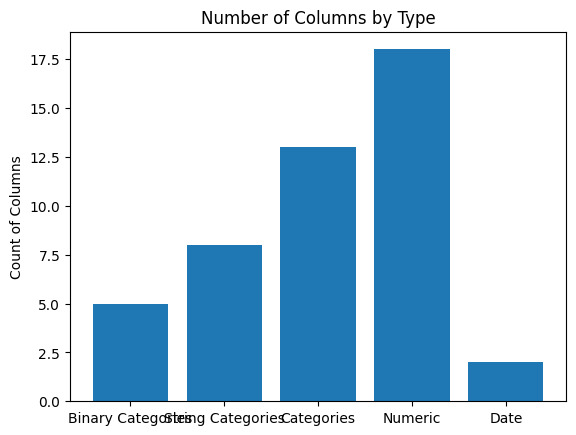

In [2]:
# Columns identified for removal
DATE_COLUMNS = ['accidentdate','claimdate',]

CATEGORY_COLUMNS = ['exceptionalcircumstances','minorpsychologicalinjury','whiplash',
                  'policereportfiled','witnesspresent','dominantinjury','vehicletype','weatherconditions','gender',
                    'accidenttype','numberofpassengers', 'accidentdescription', 'injurydescription']

CATEGORY_BINARY_COLUMNS = ['exceptionalcircumstances','minorpsychologicalinjury','whiplash',
                  'policereportfiled','witnesspresent']

# categorical columns for one-hot encoding
CATEGORY_STRING_COLUMNS = ['dominantinjury','vehicletype','weatherconditions','gender',
                    'accidenttype','numberofpassengers', 'accidentdescription', 'injurydescription']

# numerica data columns
NUMERIC_COLUMNS = ['specialreduction', 'specialrehabilitation', 'specialmedications',
    'specialhealthexpenses', 'specialoverage', 'generalrest','driverage',
    'specialadditionalinjury', 'specialearningsloss', 'specialusageloss',
    'specialassetdamage', 'specialfixes', 'generaluplift', 'specialtripcosts',
    'specialloanervehicle', 'specialjourneyexpenses', 'specialtherapy','vehicleage']

column_counts = {
    'Binary Categories': len(CATEGORY_BINARY_COLUMNS),
    'String Categories': len(CATEGORY_STRING_COLUMNS),
    'Categories': len(CATEGORY_COLUMNS),
    'Numeric': len(NUMERIC_COLUMNS),
    'Date': len(DATE_COLUMNS)
}

plt.bar(column_counts.keys(), column_counts.values())
plt.title("Number of Columns by Type")
plt.ylabel("Count of Columns")
plt.show()

# Dataset Import

This section imports the diabetes dataset provided for the assignment. The dataset is saved in csv format in the same folder as the project notebook. The file is imported into the project as a pandas dataframe object.

In [3]:
# import dataset from csv
ml_dataset = pd.read_csv('./clean_df.csv')
# confirm number of imported records matches expected size
print("Number of records imported: " + str(len(ml_dataset.index)))
ml_dataset.head()

Number of records imported: 4874


,settlementvalue,injuryprognosis,injurydescription,dominantinjury,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,...,vehicletype,weatherconditions,vehicleage,driverage,numberofpassengers,policereportfiled,witnesspresent,gender,accidentdate,claimdate
0,520,5,Whiplash and minor bruises.,Arms,1,1,0,520,0,0,...,Motorcycle,Rainy,13,33,2,1,1,Male,2023-11-10 11:22,2024-06-11 11:22
1,870,2,Minor cuts and scrapes.,Multiple,1,1,0,260,0,520,...,Motorcycle,Snowy,4,45,2,1,1,Female,2023-06-25 00:55,2024-01-09 00:55
2,2140,7,Whiplash and minor bruises.,Legs,1,0,0,840,0,1400,...,Motorcycle,Sunny,9,45,2,1,0,Female,2020-02-23 17:43,2020-03-01 17:43
3,520,4,Minor cuts and scrapes.,Arms,1,1,0,520,0,0,...,Truck,Rainy,5,62,1,1,1,Female,2021-10-02 04:36,2021-10-13 04:36
4,260,3,Concussion and bruised ribs.,Arms,0,1,0,260,0,0,...,Motorcycle,Rainy,9,78,1,1,1,Other,2023-04-02 05:13,2023-04-14 05:13


Number of records imported: 4874
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   settlementvalue           4874 non-null   int64 
 1   injuryprognosis           4874 non-null   int64 
 2   injurydescription         4874 non-null   object
 3   dominantinjury            4874 non-null   object
 4   whiplash                  4874 non-null   int64 
 5   minorpsychologicalinjury  4874 non-null   int64 
 6   exceptionalcircumstances  4874 non-null   int64 
 7   generalfixed              4874 non-null   int64 
 8   generaluplift             4874 non-null   int64 
 9   generalrest               4874 non-null   int64 
 10  specialhealthexpenses     4874 non-null   int64 
 11  specialtherapy            4874 non-null   int64 
 12  specialrehabilitation     4874 non-null   int64 
 13  specialmedications        4874 non-null   int

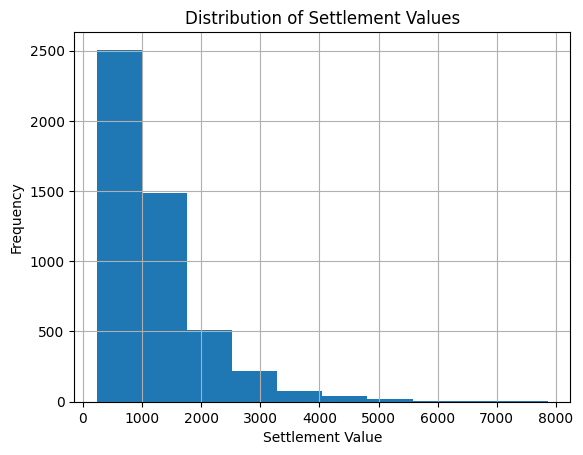

In [ ]:
ml_dataset.info()
ml_dataset.describe()

ml_dataset['settlementvalue'].hist()
plt.title("Distribution of Settlement Values")
plt.xlabel("Settlement Value")
plt.ylabel("Frequency")
plt.show()



In [5]:
## function to show histogram with distributions of settlement values against other features
def plot_settlement_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='settlementvalue', multiple='stack', bins=30)
    plt.title(f"Settlement Value Distribution by {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [4]:
# create bins for injury prognosis based on the whiplash tariff scale
# Fill missing injuryprognosis with midpoint of prognosisgroup range
imputed_prognosis = ml_dataset.copy()

# Fill missing injuryprognosis with midpoint of prognosisgroup range
for idx, row in imputed_prognosis.iterrows():
    if imputed_prognosis.at[idx, 'injuryprognosis'] <= 3:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 0
    elif 4 <= imputed_prognosis.at[idx, 'injuryprognosis'] <= 6:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 1
    elif 7 <= imputed_prognosis.at[idx, 'injuryprognosis'] <= 9:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 2
    elif 10 <= imputed_prognosis.at[idx, 'injuryprognosis'] <= 12:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 3
    elif 13<= imputed_prognosis.at[idx, 'injuryprognosis'] <= 15:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 4
    elif 16 <= imputed_prognosis.at[idx, 'injuryprognosis'] <= 18:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 5
    elif 19 <= imputed_prognosis.at[idx, 'injuryprognosis'] <= 24:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 6
    elif 25 <= imputed_prognosis.at[idx, 'injuryprognosis']:
        imputed_prognosis.at[idx, 'injuryprognosis'] = 7

imputed_prognosis['injuryprognosis'] = imputed_prognosis['injuryprognosis'].astype(int)
ml_dataset = imputed_prognosis.copy()
ml_dataset['injuryprognosis'].unique()

array([1, 0, 2, 3, 4, 5, 6])

In [7]:
claim_delay = ml_dataset.copy()
claim_delay.insert(0, 'claimdelay', 0)

# Fill missing injuryprognosis with midpoint of prognosisgroup range
for idx, row in claim_delay.iterrows():
    claim_delay.at[idx, 'claimdelay'] = pd.to_datetime(claim_delay.at[idx, 'claimdate']) - pd.to_datetime(claim_delay.at[idx, 'accidentdate'])
    claim_delay.at[idx, 'claimdelay'] = claim_delay.at[idx, 'claimdelay'].days
    if claim_delay.at[idx, 'claimdelay'] <= 30:
        claim_delay.at[idx, 'claimdelay'] = 0
    elif 30 < claim_delay.at[idx, 'claimdelay'] <= 60:
        claim_delay.at[idx, 'claimdelay'] = 1
    elif 60 < claim_delay.at[idx, 'claimdelay'] <= 90:
        claim_delay.at[idx, 'claimdelay'] = 2
    elif 90 < claim_delay.at[idx, 'claimdelay'] <= 120:
        claim_delay.at[idx, 'claimdelay'] = 3
    elif 120 < claim_delay.at[idx, 'claimdelay'] <= 150:
        claim_delay.at[idx, 'claimdelay'] = 4
    elif 150 < claim_delay.at[idx, 'claimdelay'] <= 180:
        claim_delay.at[idx, 'claimdelay'] = 5
    elif 180 < claim_delay.at[idx, 'claimdelay'] <= 240:
        claim_delay.at[idx, 'claimdelay'] = 6
    elif 240 < claim_delay.at[idx, 'claimdelay']:
        claim_delay.at[idx, 'claimdelay'] = 7
# claim_delay.drop(columns=['accidentdate','claimdate'], inplace=True)
claim_delay['claimdelay'] = claim_delay['claimdelay'].astype(int)
claim_delay['claimdelay'].unique()
claim_delay.head()


C:\Users\BB\AppData\Local\Temp\ipykernel_14028\567044622.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '214 days 00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  claim_delay.at[idx, 'claimdelay'] = pd.to_datetime(claim_delay.at[idx, 'claimdate']) - pd.to_datetime(claim_delay.at[idx, 'accidentdate'])


,claimdelay,settlementvalue,injuryprognosis,injurydescription,dominantinjury,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,...,vehicletype,weatherconditions,vehicleage,driverage,numberofpassengers,policereportfiled,witnesspresent,gender,accidentdate,claimdate
0,6,520,1,Whiplash and minor bruises.,Arms,1,1,0,520,0,...,Motorcycle,Rainy,13,33,2,1,1,Male,2023-11-10 11:22,2024-06-11 11:22
1,6,870,0,Minor cuts and scrapes.,Multiple,1,1,0,260,0,...,Motorcycle,Snowy,4,45,2,1,1,Female,2023-06-25 00:55,2024-01-09 00:55
2,0,2140,2,Whiplash and minor bruises.,Legs,1,0,0,840,0,...,Motorcycle,Sunny,9,45,2,1,0,Female,2020-02-23 17:43,2020-03-01 17:43
3,0,520,1,Minor cuts and scrapes.,Arms,1,1,0,520,0,...,Truck,Rainy,5,62,1,1,1,Female,2021-10-02 04:36,2021-10-13 04:36
4,0,260,0,Concussion and bruised ribs.,Arms,0,1,0,260,0,...,Motorcycle,Rainy,9,78,1,1,1,Other,2023-04-02 05:13,2023-04-14 05:13


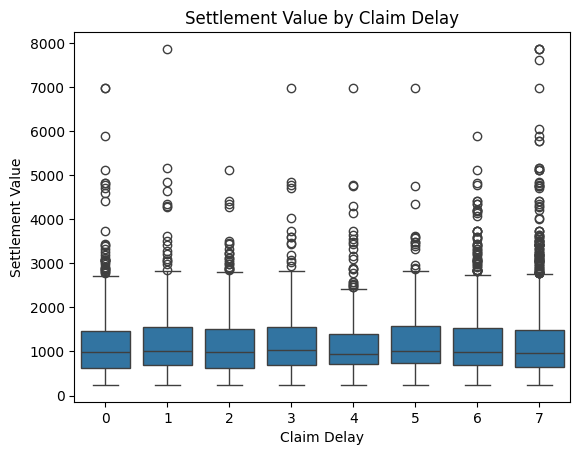

In [8]:
claim_delay['claimdelay'].unique()
sns.boxplot(x=claim_delay['claimdelay'], y=claim_delay['settlementvalue'])
plt.title("Settlement Value by Claim Delay")
plt.xlabel('Claim Delay')
plt.ylabel('Settlement Value')
plt.show()

Date duration between accident date and claim date has no impact on the settlement distribution.

## Check for mutual information between categorical string columns and settlement value and injury prognosis

In [ ]:
# use mutual_info_regression to calculate the mutual information between the target column and each feature column
def check_mutual_info(df, target_col, feature_col):
    temp_df = df[[target_col, feature_col]]
    temp_df = temp_df.dropna()

    count = 0
    mutual_info = mutual_info_regression(temp_df[[feature_col]], temp_df[target_col])
    if mutual_info > 0.05:
        print(f'Mutual Information between {target_col} and {feature_col}: {mutual_info}')
        count += 1
    else:
        pass
        ## print(f'Mutual Information between {target_col} and {feature_col} not statistically significant: {mutual_info}')
    return count

In [ ]:
cat_cols = ['dominantinjury','vehicletype','weatherconditions','injurydescription',
            'accidentdescription','numberofpassengers','gender','vehicleage','driverage',
            'policereportfiled','witnesspresent','accidenttype']
mi_df = ml_dataset.copy()
for col in cat_cols:
    temp_df = mi_df[['settlementvalue',col]]
    # temp_df = mi_df[['settlementvalue','injuryprognosis',col]]
    # one hot encode the categorical column
    temp_df = pd.get_dummies(temp_df, columns=[col])
    temp_df = temp_df.dropna()
    # normalize the settlement column
    # temp_df[['settlementvalue']] = scaler.fit_transform(temp_df[['settlementvalue']])
    temp_df[['settlementvalue']] = temp_df[['settlementvalue']]
    # print('temp_df for col:', col)
    # print(temp_df.head())
    # display correlation matrix for temp_df
    count = 0

    for cat_col in temp_df.columns:
        if cat_col != 'settlementvalue' and cat_col != 'injuryprognosis':
            count += check_mutual_info(temp_df, 'settlementvalue', cat_col)
    #display(temp_df.corr())
    if count == 0:
        print('No Mutual Information found for column:', col)
    # check_correlation(temp_df, 'settlementvalue', col)

No Mutual Information found for column: dominantinjury
No Mutual Information found for column: vehicletype
No Mutual Information found for column: weatherconditions
No Mutual Information found for column: injurydescription
No Mutual Information found for column: accidentdescription
No Mutual Information found for column: numberofpassengers
No Mutual Information found for column: gender
No Mutual Information found for column: vehicleage
No Mutual Information found for column: driverage
No Mutual Information found for column: policereportfiled
No Mutual Information found for column: witnesspresent
Mutual Information between settlementvalue and accidenttype_Other: [0.07922945]
Mutual Information between settlementvalue and accidenttype_Other side changed lanes and collided with clt's vehicle: [0.05134729]
Mutual Information between settlementvalue and accidenttype_Other side pulled out of side road: [0.11863983]
Mutual Information between settlementvalue and accidenttype_Other side revers

In [12]:
CHART_TYPE = ['scatter','histogram','distribution_histogram','boxplot','violinplot','heatmap']
##cols = [col for col in ml_dataset.columns if col != 'settlementvalue']
cols = [col for col in ml_dataset.columns]
settlementvalue = 'settlementvalue' in ml_dataset.columns
# cols = [col for col in claim_delay.columns]
# settlementvalue = 'settlementvalue' in claim_delay.columns

# df = claim_delay.copy()
df = ml_dataset.copy()

output = widgets.Output()
# --- Create interactive widgets ---
if CHART_TYPE:
    # Dropdown to select a numeric column
    chart_dropdown = widgets.Dropdown(
        options=CHART_TYPE,
        description="Chart:"
    )

    col1_dropdown = widgets.Dropdown(
        options=cols,
        description="X Axis Column:"
    )

    col2_dropdown = widgets.Dropdown(
        options=cols,
        description="Y Axis Column:"
    )
    
    # Callback function to update the histogram based on selections
    def update_chart(change):
        with output:
            output.clear_output(wait=True)
            plt.figure(figsize=(6, 4))
            chart = chart_dropdown.value
            col1 = col1_dropdown.value
            col2 = col2_dropdown.value
            
            
            if chart == 'scatter':
                title = f"{chart} of {col1_dropdown.value} vs {col2_dropdown.value}"
                plt.title(title)
                plt.scatter(df[col1], df[col2])
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.show()
            elif chart == 'histogram':
                plt.hist2d(df[col1], settlementvalue, bins=10, cmap='Blues')
                plt.xlabel(col1)
                plt.ylabel(settlementvalue)
                plt.show()
            elif chart == 'boxplot':
                sns.boxplot(x=df[col1], y=df[col2])
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.show()
            elif chart == 'violinplot':
                sns.violinplot(x=df[col1], y=df[col2])
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.show()
            elif chart == 'distribution_histogram':
                # sns.histplot(data=df, x=col1, hue='settlementvalue', multiple='stack', bins=10)
                # # plt.hist(df[col1], bins=10, density=True, alpha=0.5, color='g')
                # # sns.kdeplot(df[col1], color='r')
                # plt.xlabel(col1)
                # plt.ylabel('Density')
                plt.title(f"Settlement Value Distribution by {col1}")
                plt.show()
            elif chart == 'heatmap':
                title = f"{chart}"
                plt.title(title)
                #corr = df.corr()
                # calculate the feature correlation values
                c = df.select_dtypes('number').corr().round(3)
                sns.heatmap(c, annot=False)
                plt.show()
                # sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

    


    # Observe changes so that the chart updates when selection changes
    chart_dropdown.observe(update_chart, names='value')
    col1_dropdown.observe(update_chart, names='value')
    col2_dropdown.observe(update_chart, names='value')
    
    # Display the dropdowns in a horizontal layout
    display(widgets.HBox([chart_dropdown, col1_dropdown, col2_dropdown]), output)
    
    # Draw an initial chart
    update_chart(None)
else:
    print("Error loading visualization.")


Output()

In [20]:
REMOVE_VALUES_FROM = ['specialhealthexpenses','specialfixes','specialrehabilitation','specialadditionalinjury']
##remove rows with values in these columns
reduced_df = ml_dataset.copy()
for idx, row in reduced_df.iterrows():
    for col in REMOVE_VALUES_FROM:
        if reduced_df.at[idx, col] != 0:
            reduced_df.drop(idx, inplace=True)
            break
print(f"Number of records after removing outliers: {len(reduced_df.index)}")
reduced_df.head()

Number of records after removing outliers: 4837


,settlementvalue,injuryprognosis,injurydescription,dominantinjury,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,...,vehicletype,weatherconditions,vehicleage,driverage,numberofpassengers,policereportfiled,witnesspresent,gender,accidentdate,claimdate
0,520,1,Whiplash and minor bruises.,Arms,1,1,0,520,0,0,...,Motorcycle,Rainy,13,33,2,1,1,Male,2023-11-10 11:22,2024-06-11 11:22
1,870,0,Minor cuts and scrapes.,Multiple,1,1,0,260,0,520,...,Motorcycle,Snowy,4,45,2,1,1,Female,2023-06-25 00:55,2024-01-09 00:55
2,2140,2,Whiplash and minor bruises.,Legs,1,0,0,840,0,1400,...,Motorcycle,Sunny,9,45,2,1,0,Female,2020-02-23 17:43,2020-03-01 17:43
3,520,1,Minor cuts and scrapes.,Arms,1,1,0,520,0,0,...,Truck,Rainy,5,62,1,1,1,Female,2021-10-02 04:36,2021-10-13 04:36
4,260,0,Concussion and bruised ribs.,Arms,0,1,0,260,0,0,...,Motorcycle,Rainy,9,78,1,1,1,Other,2023-04-02 05:13,2023-04-14 05:13


In [21]:
DROP_COLUMNS = ['driverage','vehicleage','accidentdate','claimdate','policereportfiled','witnesspresent','dominantinjury','vehicletype','weatherconditions','gender','numberofpassengers', 'accidentdescription', 'injurydescription']
reduced_df = ml_dataset.copy()
reduced_df.drop(columns=DROP_COLUMNS, inplace=True)
# confirm number of records imported matches expected size
print("Number of records imported: " + str(len(reduced_df.index)))
reduced_df.head()

Number of records imported: 4874


,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,870,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,2140,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,260,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


In [5]:
DROP_COLUMNS = ['driverage','vehicleage','accidentdate','claimdate','policereportfiled','witnesspresent','dominantinjury','vehicletype','weatherconditions','gender','numberofpassengers', 'accidentdescription', 'injurydescription']
reduced_df = ml_dataset.copy()
reduced_df.drop(columns=DROP_COLUMNS, inplace=True)
# confirm number of records imported matches expected size
print("Number of records imported: " + str(len(reduced_df.index)))
reduced_df.head()

Number of records imported: 4874


,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,870,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,2140,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,260,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


In [22]:
# convert retained categorical column to category type
reduced_df['accidenttype'] = reduced_df['accidenttype'].astype('category')

In [184]:
## use df_norm for models that require scaled data for training 
def make_df_norm(df, cols=None, scaler=None):
    if cols:
        df_norm = df.copy()
        numeric_cols = [col for col in cols if col in df_norm.columns]
        df_norm[numeric_cols] = scaler.fit_transform(df_norm[numeric_cols])
        return df_norm

In [ ]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=True)
def make_sparse(df):
    # Convert the DataFrame to a dictionary of records
    records = df.to_dict(orient='records')
    # Use DictVectorizer to convert the records to a sparse matrix
    sparse_matrix = v.fit_transform(records)
    sparse_matrix.eliminate_zeros()
    return sparse_matrix

In [17]:
## Convert sparse matrix to DataFrame
sparse_df = make_sparse(reduced_df)
unsparse_df = pd.DataFrame(sparse_df.toarray(), columns=v.get_feature_names_out())
unsparse_df.head()

,accidenttype=Other,accidenttype=Other side changed lanes and collided with clt's vehicle,accidenttype=Other side changed lanes on a roundabout colliding with clt's vehicle,accidenttype=Other side collided with Clt's parked vehicle,accidenttype=Other side drove on wrong side of the road,"accidenttype=Other side opened their door, hitting clt's vehicle",accidenttype=Other side overtook and hit Clt when pulling in,accidenttype=Other side overtook and pulled in too soon,accidenttype=Other side overtook whilst clt was turning right,accidenttype=Other side pulled from parked position into the path of clt's vehicle,...,specialjourneyexpenses,specialloanervehicle,specialmedications,specialoverage,specialreduction,specialrehabilitation,specialtherapy,specialtripcosts,specialusageloss,whiplash
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
reduced_df.head()

,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,870,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,2140,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,260,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


In [ ]:
# function to one-hot encode a categorical column
def one_hot_encode(df, columns):
    for column in columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df = df.drop(column, axis=1)
    return df

In [196]:
def calc_shap(df, model, one_hot=False, normalise=False, sparsify=False):
    if normalise:
        scaler = RobustScaler(with_centering=False, with_scaling=False)
        # scaler = MinMaxScaler()
        # scaler = StandardScaler()
        df = make_df_norm(df, cols=NUMERIC_COLUMNS, scaler=scaler)
    if one_hot:
        df = one_hot_encode(df, cols=CATEGORY_COLUMNS)
    if model == 'Random Forest':
        model = RandomForestRegressor()
    elif model == 'Linear Regression':
        df = scaler.fit_transform(df)
        model = LinearRegression()
    elif model == 'Gradient Boosting':
        model = GradientBoostingRegressor()
    elif model == 'AdaBoost':
        model = AdaBoostRegressor()
    elif model == 'SVR':
        df = scaler.fit_transform(df)
        model = SVR()
    elif model == 'XGBoost':
        model = xgboost.XGBRegressor(n_estimators=10, max_depth=20, enable_categorical=True, verbosity=2)
    elif model == 'Ridge':
        df = scaler.fit_transform(df)
        model = Ridge()
    elif model == 'Extra Trees':
        model = ExtraTreesRegressor
    else:
        raise ValueError('Invalid model selected')
    
    X = df.drop("settlementvalue", axis=1) # Independent variables
    if sparsify:
        X = make_sparse(X)
    y = df.settlementvalue # Dependent variable

    # Split into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # Train a machine learning model
    model.fit(X_train, y_train)

    # Make prediction on the testing data
    pred = model.predict(X_test)

    print(f"r2 score: {r2_score(pred, y_test)}")
    print(f"MAPE score: {mean_absolute_percentage_error(pred, y_test)}")
    print(f"RMSE_score: {root_mean_squared_error(pred, y_test)}")

    if (model == 'SVR') or (model == 'Ridge'):
        explainer = shap.Explainer(model.predict, X_test)
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    shap.decision_plot(explainer.expected_value, shap_values, X_test.columns)

In [ ]:
reduced_df.head()

,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,870,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,2140,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,520,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,260,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


[04:24:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 22, 74470).
r2 score: 0.8759831190109253
MAPE score: 0.07769524306058884
RMSE_score: 281.5596008300781


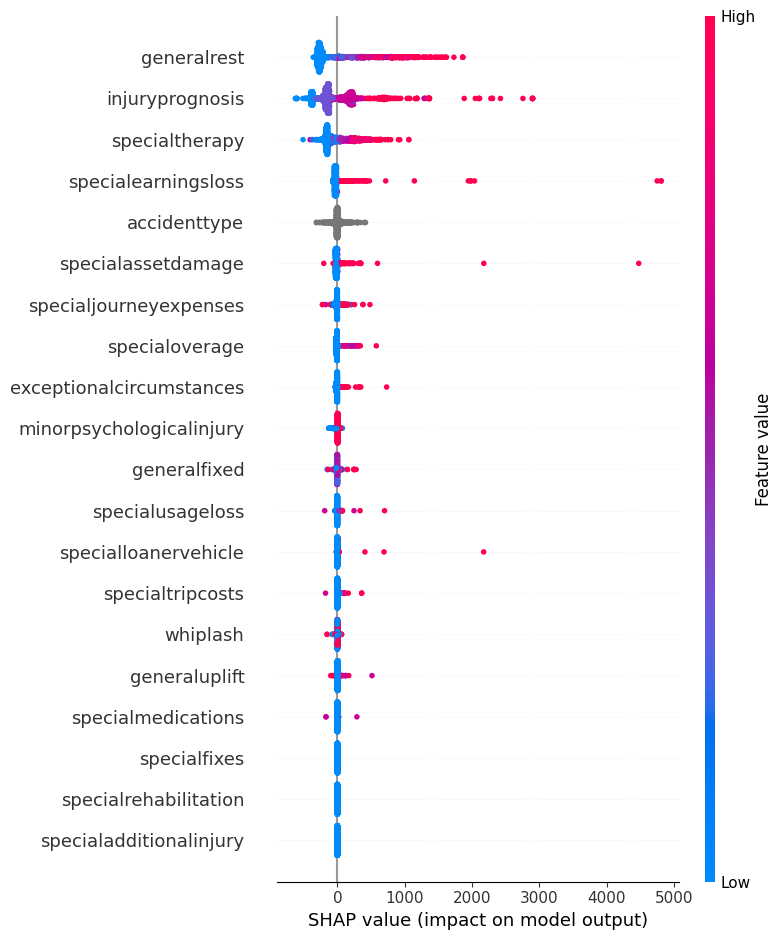

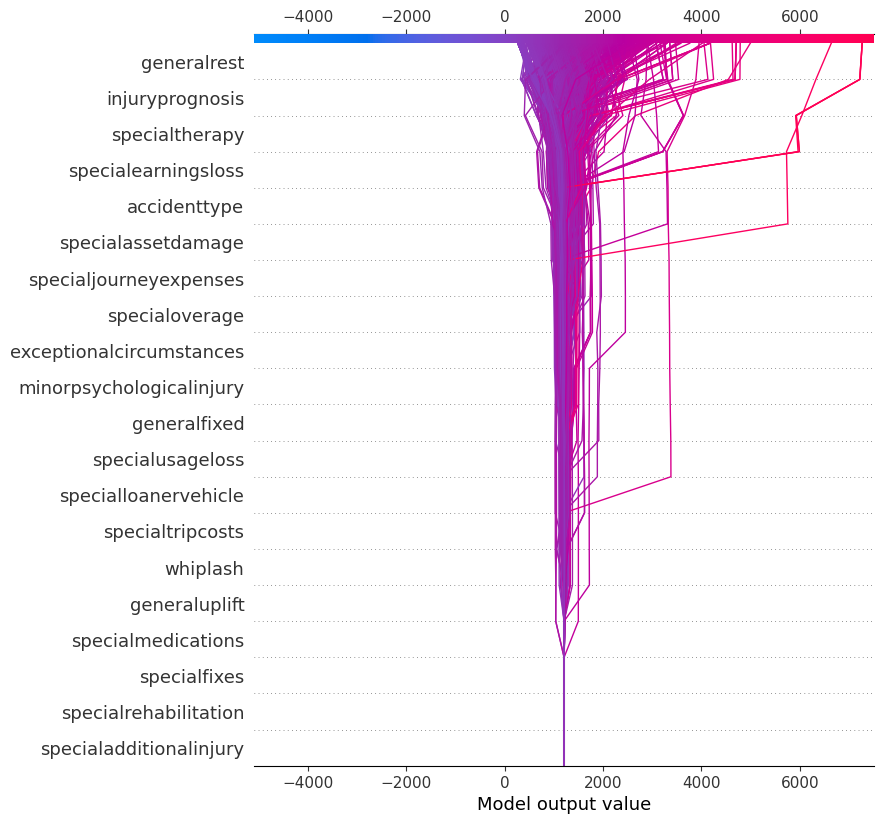

In [190]:
calc_shap(reduced_df, model='XGBoost', normalise=True)

[04:26:41] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 40, 19128).
r2 score: 0.8874862194061279
MAPE score: 0.07654335349798203
RMSE_score: 268.74993896484375


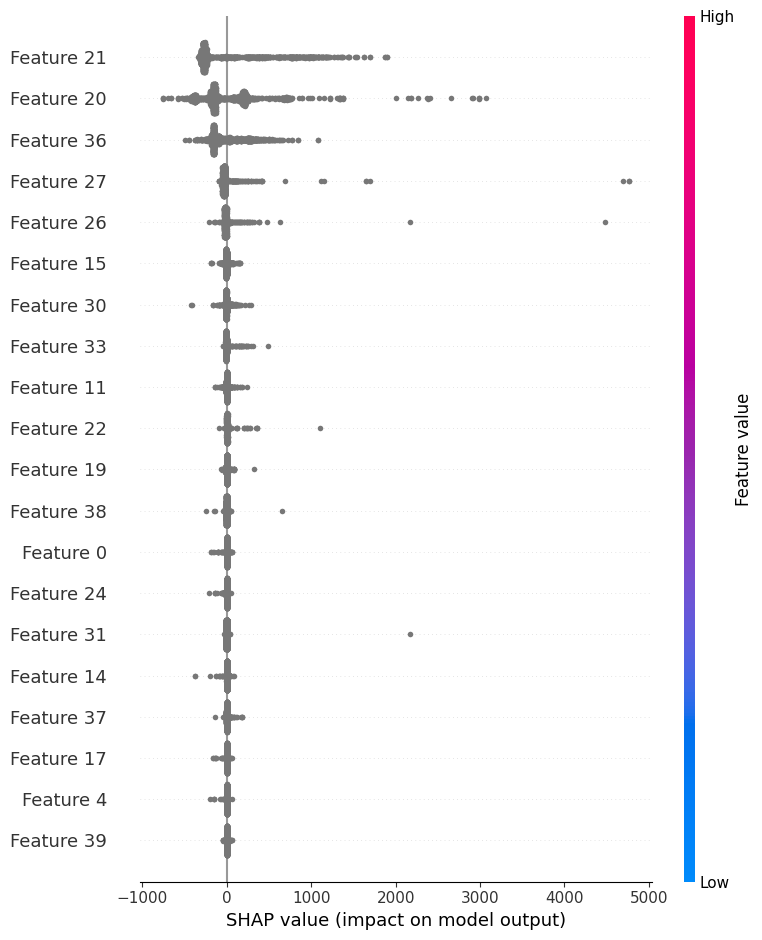

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [197]:
calc_shap(reduced_df, model='XGBoost', normalise=True, sparsify=True)

[04:02:57] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 40, 19128).
r2 score: 0.8874862194061279
MAPE score: 0.07654335349798203
RMSE_score: 268.74993896484375


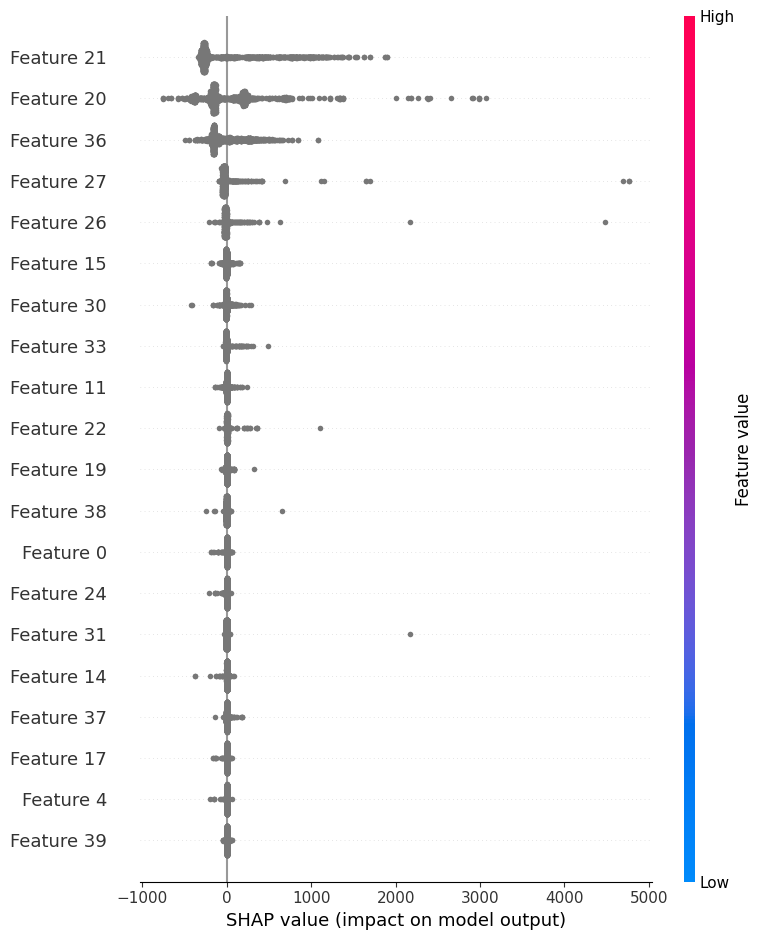

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [ ]:
calc_shap(reduced_df.copy(), 'XGBoost')

In [23]:
df = reduced_df.copy()
df.head()
# apply log1p to settlementvalue to reduce skewness
df['settlementvalue'] = np.log1p(df['settlementvalue'])
for col in CATEGORY_COLUMNS:
    if col in df.columns:
        df[col] = df[col].astype('category')


X = df.drop("settlementvalue", axis=1) # Independent variables
y = df.settlementvalue # Dependent variable

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
df.head()

X_train shape: (3411, 22)
X_test shape: (1463, 22)
y_train shape: (3411,)
y_test shape: (1463,)


,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,6.769642,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,7.669028,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,5.564520,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


[05:10:22] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3411, 22, 75042).
[05:10:22] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1463, 22, 32186).
[0]	validation_0-rmsle:0.06420


[1]	validation_0-rmsle:0.05071
[2]	validation_0-rmsle:0.04200
[3]	validation_0-rmsle:0.03617
[4]	validation_0-rmsle:0.03245
[5]	validation_0-rmsle:0.03005
[6]	validation_0-rmsle:0.02842
[7]	validation_0-rmsle:0.02724
[8]	validation_0-rmsle:0.02630
[9]	validation_0-rmsle:0.02560
[10]	validation_0-rmsle:0.02512
[11]	validation_0-rmsle:0.02467
[12]	validation_0-rmsle:0.02437
[13]	validation_0-rmsle:0.02413
[14]	validation_0-rmsle:0.02399
[15]	validation_0-rmsle:0.02385
[16]	validation_0-rmsle:0.02375
[17]	validation_0-rmsle:0.02363
[18]	validation_0-rmsle:0.02359
[19]	validation_0-rmsle:0.02352
[20]	validation_0-rmsle:0.02340
[21]	validation_0-rmsle:0.02314
[22]	validation_0-rmsle:0.02303
[23]	validation_0-rmsle:0.02297
[24]	validation_0-rmsle:0.02292
[25]	validation_0-rmsle:0.02283
[26]	validation_0-rmsle:0.02280
[27]	validation_0-rmsle:0.02280
[28]	validation_0-rmsle:0.02280
[29]	validation_0-rmsle:0.02274
[30]	validation_0-rmsle:0.02273
[31]	validation_0-rmsle:0.02273
[32]	validation_0

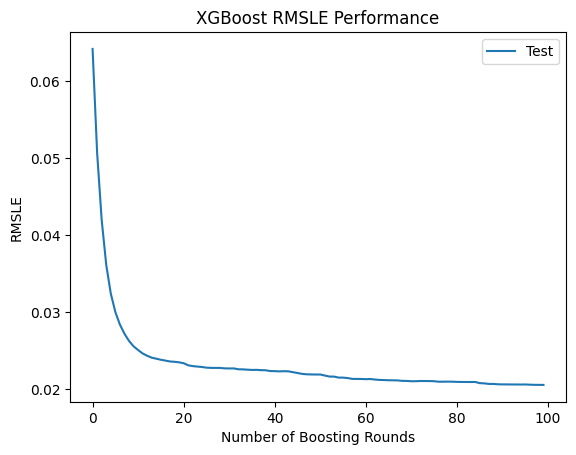

Final RMSLE on test set: 0.0206
r2 score: 0.9319952737059227
MAPE score: 0.010881895603637828
RMSE_score: 0.16748961718865019
Inverse Log of RMSLE:182.33301418055333


In [ ]:
# with columns removed but not extreme outliers
# Train a machine learning model
xgb = xgboost.XGBRegressor(n_estimators=100, eval_metric='rmsle', early_stopping_rounds=10, enable_categorical=True, verbosity=2)
# xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Retrieve the RMSLE values from the training process
results = xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# Plot the RMSLE values
plt.figure()
plt.plot(x_axis, results['validation_0']['rmsle'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSLE')
plt.title('XGBoost RMSLE Performance')
plt.show()

# Make predictions and evaluate the final RMSLE on the test set
y_pred = xgb.predict(X_test)
final_rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_test))))
print(f"Final RMSLE on test set: {final_rmsle:.4f}")
print(f"r2 score: {r2_score(y_pred, y_test)}")
print(f"MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}")
print(f"RMSE_score: {root_mean_squared_error(y_pred, y_test)}")
print(f"Inverse Log of RMSLE:{np.expm1(root_mean_squared_error(y_pred, y_test))*1000}")

In [13]:
print(type(y_pred))
print(type(y_test))
print(y_pred.shape)
print(y_test.shape)
print(y_pred[:10])


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
(1463,)
(1463,)
[6.297281  7.9349723 7.122523  7.442176  6.316516  7.2359385 5.4901752
 6.392643  6.9137077 7.6710057]


In [24]:
df = reduced_df.copy()
df.head()
# apply log1p to settlementvalue to reduce skewness
df['settlementvalue'] = np.log1p(df['settlementvalue'])
for col in CATEGORY_COLUMNS:
    if col in df.columns:
        df[col] = df[col].astype('category')


X = df.drop("settlementvalue", axis=1) # Independent variables
y = df.settlementvalue # Dependent variable

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
df.head()

X_train shape: (3411, 22)
X_test shape: (1463, 22)
y_train shape: (3411,)
y_test shape: (1463,)


,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,6.769642,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,7.669028,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,5.564520,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


[04:33:15] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 22, 74470).
[04:33:15] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1452, 22, 31944).
[0]	validation_0-rmsle:0.58094
[1]	validation_0-rmsle:0.48929


[2]	validation_0-rmsle:0.42090
[3]	validation_0-rmsle:0.36219
[4]	validation_0-rmsle:0.32593
[5]	validation_0-rmsle:0.29038
[6]	validation_0-rmsle:0.26769
[7]	validation_0-rmsle:0.25190
[8]	validation_0-rmsle:0.23382
[9]	validation_0-rmsle:0.22227
[10]	validation_0-rmsle:0.21474
[11]	validation_0-rmsle:0.20994
[12]	validation_0-rmsle:0.20549
[13]	validation_0-rmsle:0.20084
[14]	validation_0-rmsle:0.19710
[15]	validation_0-rmsle:0.19578
[16]	validation_0-rmsle:0.19433
[17]	validation_0-rmsle:0.19202
[18]	validation_0-rmsle:0.19046
[19]	validation_0-rmsle:0.18521
[20]	validation_0-rmsle:0.18516
[21]	validation_0-rmsle:0.18332
[22]	validation_0-rmsle:0.18309
[23]	validation_0-rmsle:0.17933
[24]	validation_0-rmsle:0.17813
[25]	validation_0-rmsle:0.17645
[26]	validation_0-rmsle:0.17632
[27]	validation_0-rmsle:0.17605
[28]	validation_0-rmsle:0.17559
[29]	validation_0-rmsle:0.17395
[30]	validation_0-rmsle:0.17294
[31]	validation_0-rmsle:0.17210
[32]	validation_0-rmsle:0.17159
[33]	validation_

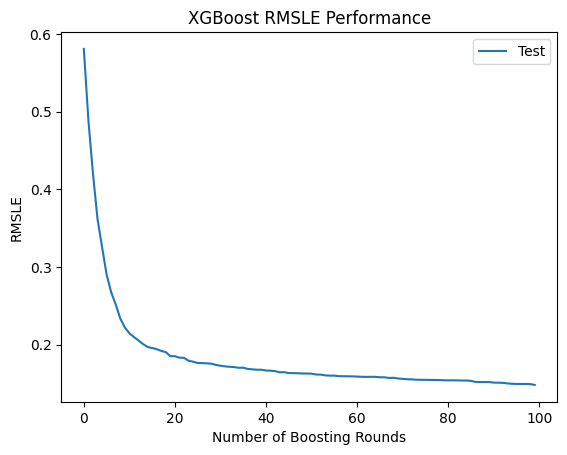

Final RMSLE on test set: 0.1482
r2 score: 0.9047450423240662
MAPE score: 0.0735851526260376
RMSE_score: 259.3817138671875
Inverse Log of RMSLE:4.446794287987062e+115


In [204]:
# without applying log1p to settlementvalue
# Train a machine learning model
xgb = xgboost.XGBRegressor(n_estimators=100, eval_metric='rmsle', early_stopping_rounds=10, enable_categorical=True, verbosity=2)
# xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Retrieve the RMSLE values from the training process
results = xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# Plot the RMSLE values
plt.figure()
plt.plot(x_axis, results['validation_0']['rmsle'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSLE')
plt.title('XGBoost RMSLE Performance')
plt.show()

# Make predictions and evaluate the final RMSLE on the test set
y_pred = xgb.predict(X_test)
final_rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_test))))
print(f"Final RMSLE on test set: {final_rmsle:.4f}")
print(f"r2 score: {r2_score(y_pred, y_test)}")
print(f"MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}")
print(f"RMSE_score: {root_mean_squared_error(y_pred, y_test)}")
print(f"Inverse Log of RMSLE:{np.expm1(root_mean_squared_error(y_pred, y_test))*1000}")

[06:04:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3411, 22, 75042).
[06:04:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1463, 22, 32186).
[0]	validation_0-rmsle:0.06420


[1]	validation_0-rmsle:0.05071
[2]	validation_0-rmsle:0.04200
[3]	validation_0-rmsle:0.03617
[4]	validation_0-rmsle:0.03245
[5]	validation_0-rmsle:0.03005
[6]	validation_0-rmsle:0.02842
[7]	validation_0-rmsle:0.02724
[8]	validation_0-rmsle:0.02630
[9]	validation_0-rmsle:0.02560
[10]	validation_0-rmsle:0.02512
[11]	validation_0-rmsle:0.02467
[12]	validation_0-rmsle:0.02437
[13]	validation_0-rmsle:0.02413
[14]	validation_0-rmsle:0.02399
[15]	validation_0-rmsle:0.02385
[16]	validation_0-rmsle:0.02375
[17]	validation_0-rmsle:0.02363
[18]	validation_0-rmsle:0.02359
[19]	validation_0-rmsle:0.02352
[20]	validation_0-rmsle:0.02340
[21]	validation_0-rmsle:0.02314
[22]	validation_0-rmsle:0.02303
[23]	validation_0-rmsle:0.02297
[24]	validation_0-rmsle:0.02292
[25]	validation_0-rmsle:0.02283
[26]	validation_0-rmsle:0.02280
[27]	validation_0-rmsle:0.02280
[28]	validation_0-rmsle:0.02280
[29]	validation_0-rmsle:0.02274
[30]	validation_0-rmsle:0.02273
[31]	validation_0-rmsle:0.02273
[32]	validation_0

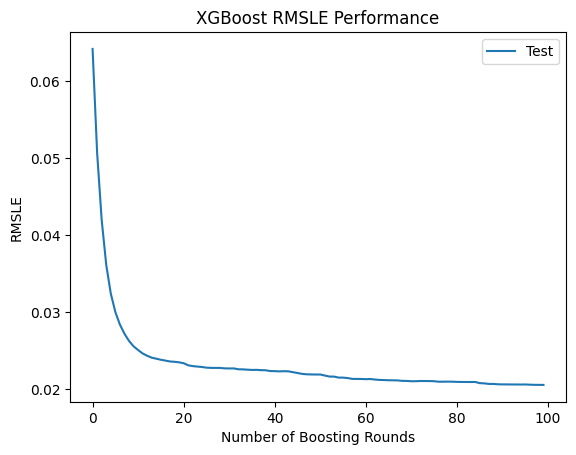

Final RMSLE on test set: 0.0206
r2 score: 0.9319952737059227
MAPE score: 0.010881895603637828
RMSE_score: 0.16748961718865019
Inverse Log of RMSLE:182.33301418055333


In [25]:
# With log1p applied to settlementvalue
# Train a machine learning model
xgb = xgboost.XGBRegressor(n_estimators=100, eval_metric='rmsle', early_stopping_rounds=10, enable_categorical=True, verbosity=2)
# xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Retrieve the RMSLE values from the training process
results = xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# Plot the RMSLE values
plt.figure()
plt.plot(x_axis, results['validation_0']['rmsle'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSLE')
plt.title('XGBoost RMSLE Performance')
plt.show()

# Make predictions and evaluate the final RMSLE on the test set
y_pred = xgb.predict(X_test)
final_rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_test))))
print(f"Final RMSLE on test set: {final_rmsle:.4f}")
print(f"r2 score: {r2_score(y_pred, y_test)}")
print(f"MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}")
print(f"RMSE_score: {root_mean_squared_error(y_pred, y_test)}")
print(f"Inverse Log of RMSLE:{np.expm1(root_mean_squared_error(y_pred, y_test))*1000}")

In [228]:
# convert settlementvalue back to original scale
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

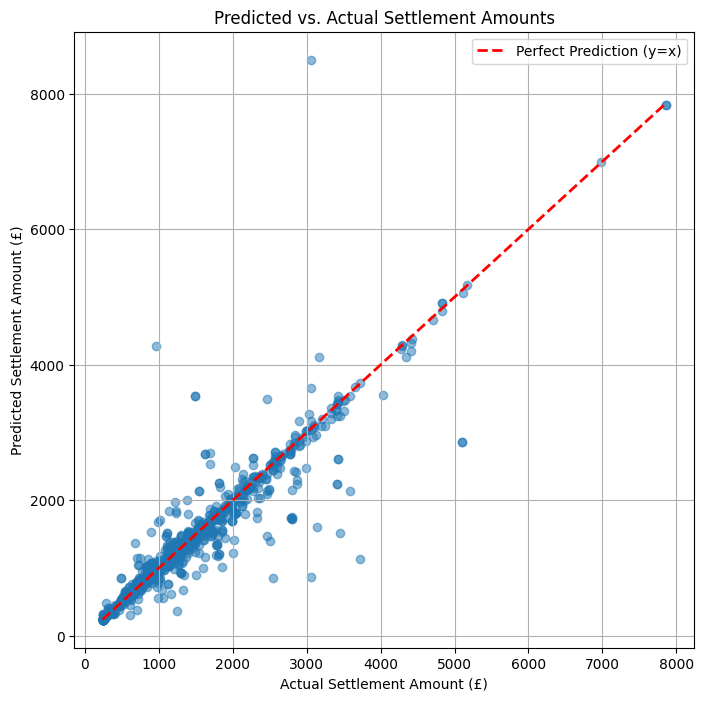

In [229]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction (y=x)') # Add y=x line
plt.xlabel("Actual Settlement Amount (£)")
plt.ylabel("Predicted Settlement Amount (£)")
plt.title("Predicted vs. Actual Settlement Amounts")
plt.legend()
plt.grid(True)
plt.show()

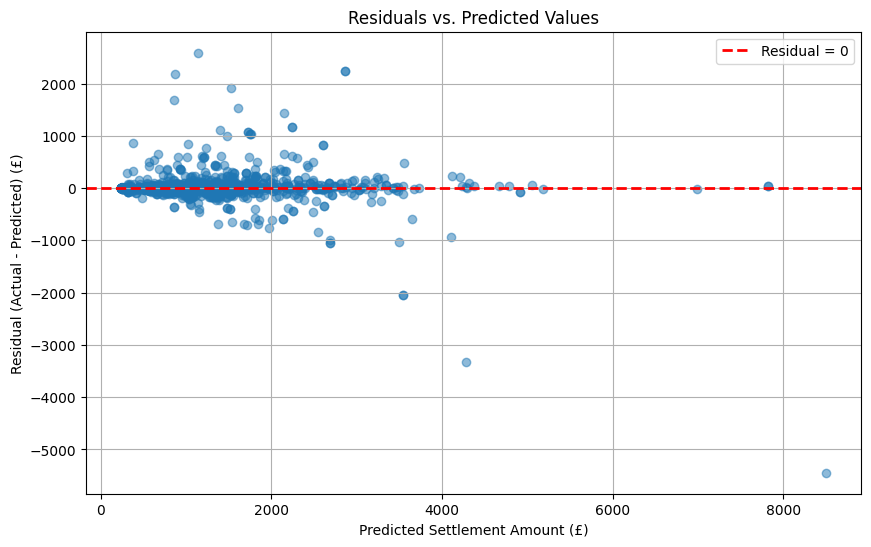

C:\Users\BB\AppData\Local\Temp\ipykernel_14028\3627031329.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


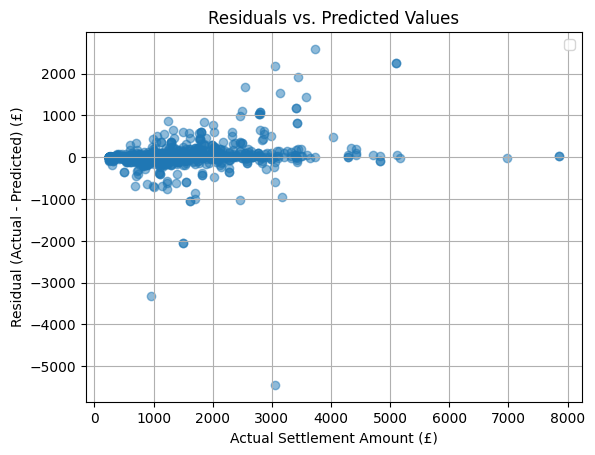

In [230]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2, label='Residual = 0') # Add y=0 line
plt.xlabel("Predicted Settlement Amount (£)")
plt.ylabel("Residual (Actual - Predicted) (£)")
plt.title("Residuals vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# You can also plot residuals vs ACTUAL values:
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Settlement Amount (£)")
plt.ylabel("Residual (Actual - Predicted) (£)")
plt.title("Residuals vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

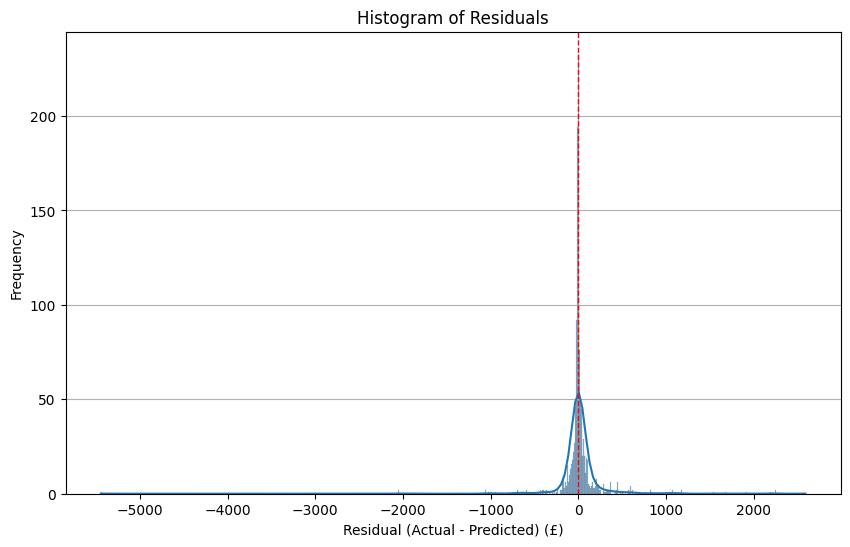

Mean Residual: 14.76
Median Residual: -0.98


In [231]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Seaborn often makes nicer histograms

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True) # kde=True adds a density curve
plt.xlabel("Residual (Actual - Predicted) (£)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.grid(True, axis='y')
plt.show()

print(f"Mean Residual: {np.mean(residuals):.2f}")
print(f"Median Residual: {np.median(residuals):.2f}")

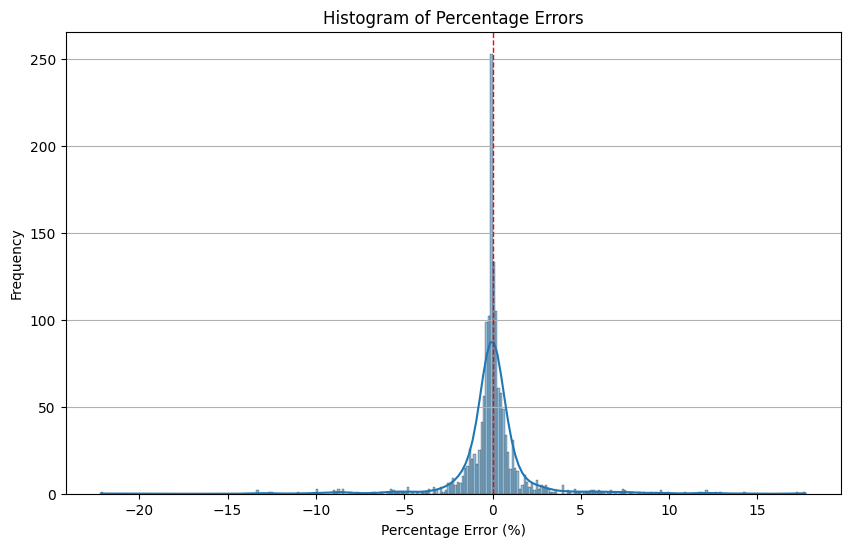

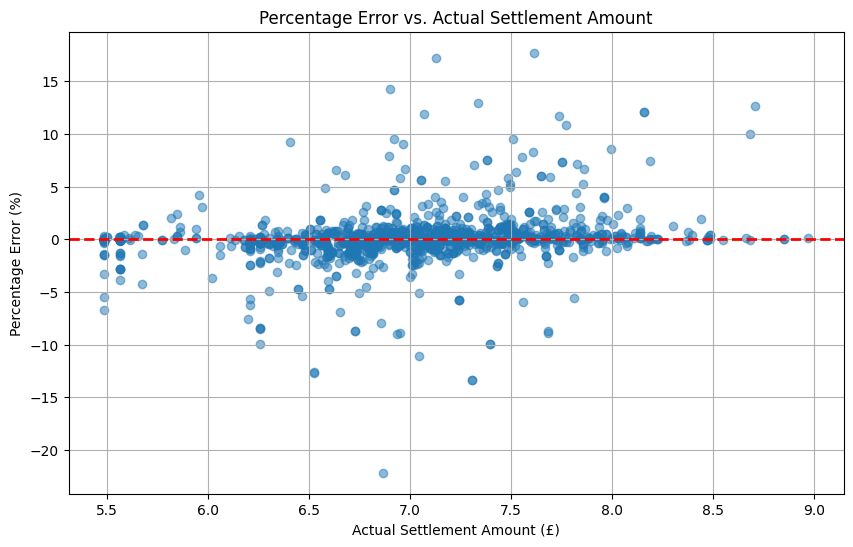

Mean Absolute Percentage Error (MAPE): inf%
Median Absolute Percentage Error: 0.39%


ValueError: Input contains infinity or a value too large for dtype('float64').

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate percentage error - handle potential division by zero if actual can be zero (unlikely given your range)
# Adding a small epsilon to denominator is safer if zeros ARE possible, but here likely okay.
percentage_error = ((y_test - y_pred) / y_test) * 100

# Histogram of Percentage Error
plt.figure(figsize=(10, 6))
sns.histplot(percentage_error, kde=True)
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.title("Histogram of Percentage Errors")
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.grid(True, axis='y')
plt.show()

# Scatter plot of Percentage Error vs Actual Value
plt.figure(figsize=(10, 6))
plt.scatter(y_test, percentage_error, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Actual Settlement Amount (£)")
plt.ylabel("Percentage Error (%)")
plt.title("Percentage Error vs. Actual Settlement Amount")
plt.grid(True)
plt.show()

print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs(percentage_error)):.2f}%")
print(f"Median Absolute Percentage Error: {np.median(np.abs(percentage_error)):.2f}%")
print(f"RMSE_score: {root_mean_squared_error(y_pred, y_test)}")


In [222]:
print("Min:", np.min(y_pred))
print("Max:", np.max(y_pred))

Min: 238.22046
Max: 8501.1045


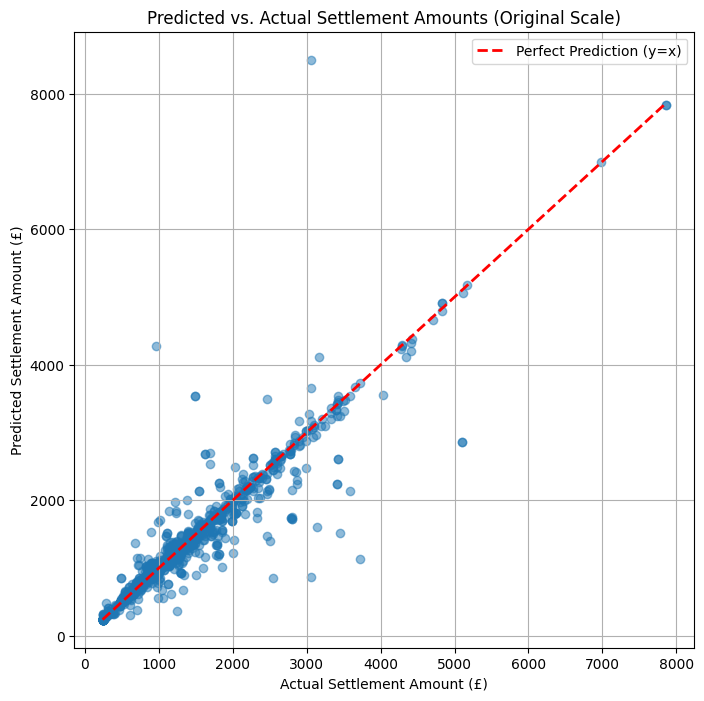

In [224]:
# convert settlementvalue back to original scale
y_pred_pounds = np.expm1(y_pred)
y_test_pounds = np.expm1(y_test)
y_pred[y_pred < 0] = 0
plt.figure(figsize=(8, 8))
# Plot reverted predictions (£) vs original actuals (£)
plt.scatter(y_test_pounds, y_pred_pounds, alpha=0.5)
plt.plot([y_test_pounds.min(), y_test_pounds.max()], [y_test_pounds.min(), y_test_pounds.max()], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel("Actual Settlement Amount (£)")
plt.ylabel("Predicted Settlement Amount (£)")
plt.title("Predicted vs. Actual Settlement Amounts (Original Scale)")
plt.legend()
plt.grid(True)
plt.show()

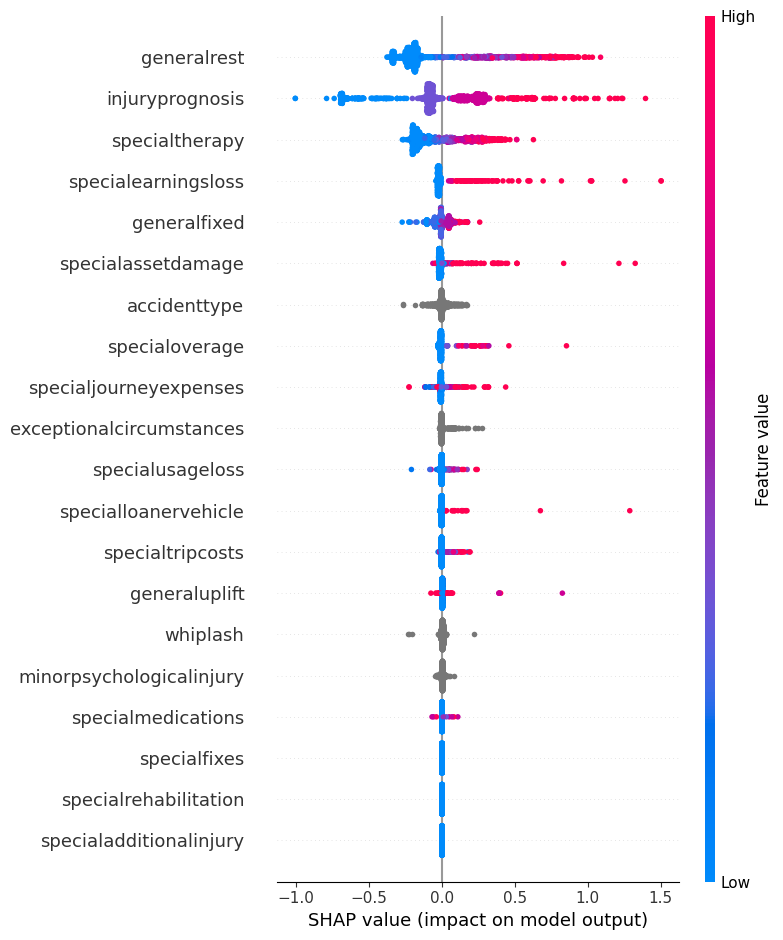

In [233]:
explainer = shap.Explainer(xgb)
xgb_shap_values = explainer.shap_values(X_test)
shap.summary_plot(xgb_shap_values, X_test)

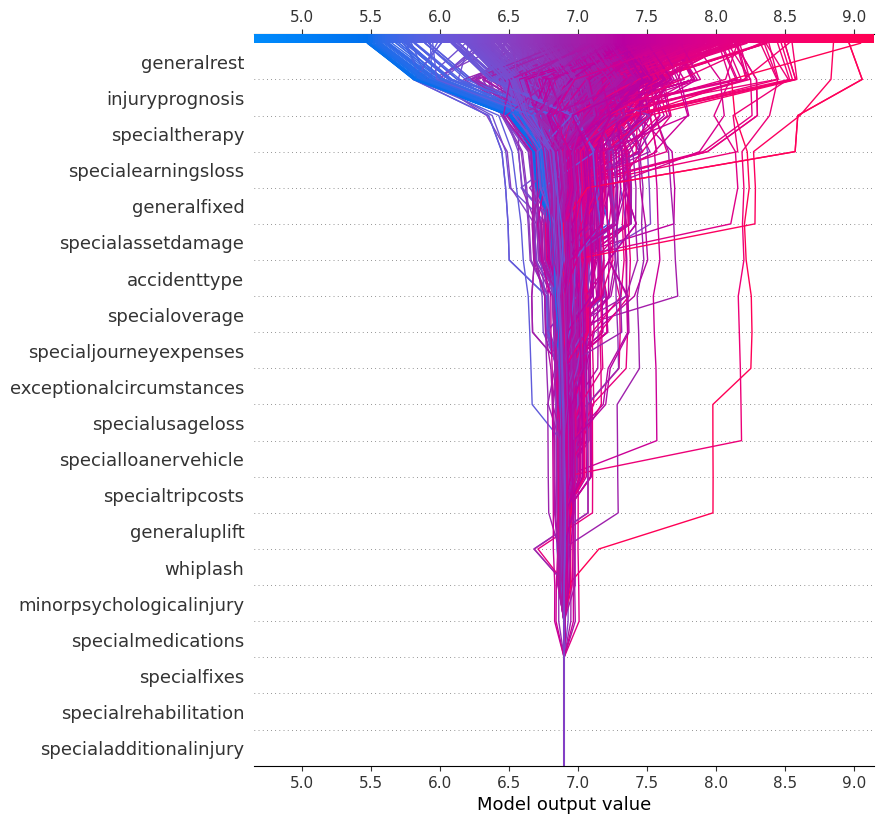

In [234]:
shap.decision_plot(explainer.expected_value, xgb_shap_values, X_test.columns)

In [ ]:
# The SHAP values are already calculated based on the original scale
# We only need to exponentiate the expected value to show impact in pounds
# Use exponentiated expected value but keep the original feature columns
shap.decision_plot(exp_expected_value, xgb_shap_values, X_test.columns, 
				  title="SHAP Decision Plot (Settlement Values in £)")

KeyError: 'settlementvalue'

In [198]:
scaler=RobustScaler(with_centering=False, with_scaling=False)
norm_df = make_df_norm(df, cols=NUMERIC_COLUMNS, scaler=scaler)

X = norm_df.drop("settlementvalue", axis=1) # Independent variables
y = norm_df.settlementvalue # Dependent variable

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
df.head()

X_train shape: (3385, 22)
X_test shape: (1452, 22)
y_train shape: (3385,)
y_test shape: (1452,)


,settlementvalue,injuryprognosis,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,specialhealthexpenses,specialtherapy,...,specialearningsloss,specialusageloss,specialreduction,specialoverage,specialassetdamage,specialfixes,specialloanervehicle,specialtripcosts,specialjourneyexpenses,accidenttype
0,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end
1,6.769642,0,1,1,0,260,0,520,0,0,...,0,90,0,0,0,0,0,0,0,Rear end
2,7.669028,2,1,0,0,840,0,1400,0,0,...,0,0,0,0,0,0,0,0,0,Other side pulled out of side road
3,6.255750,1,1,1,0,520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end - Clt pushed into next vehicle
4,5.564520,0,0,1,0,260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rear end


[04:28:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 22, 74470).
[04:28:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1452, 22, 31944).
[0]	validation_0-rmsle:0.06537
[1]	validation_0-rmsle:0.05118
[2]	validation_0-rmsle:0.04142
[3]	validation_0-rmsle:0.03498
[4]	validation_0-rmsle:0.03091
[5]	validation_0-rmsle:0.02848
[6]	validation_0-rmsle:0.02650
[7]	validation_0-rmsle:0.02549
[8]	validation_0-rmsle:0.02474
[9]	validation_0-rmsle:0.02418
[10]	validation_0-rmsle:0.02367
[11]	validation_0-rmsle:0.02332
[12]	validation_0-rmsle:0.02294
[13]	validation_0-rmsle:0.02268
[14]	validation_0-rmsle:0.02222
[15]	validation_0-rmsle:0.02203
[16]	validation_0-rmsle:0.02196
[17]	validation_0-rmsle:0.02183
[18]	validation_0-rmsle:0.02170
[19]	validation_0-rmsle:0.02148
[20]	validation_0-rmsle:0.02139
[21]	validation_0-rmsle:0.

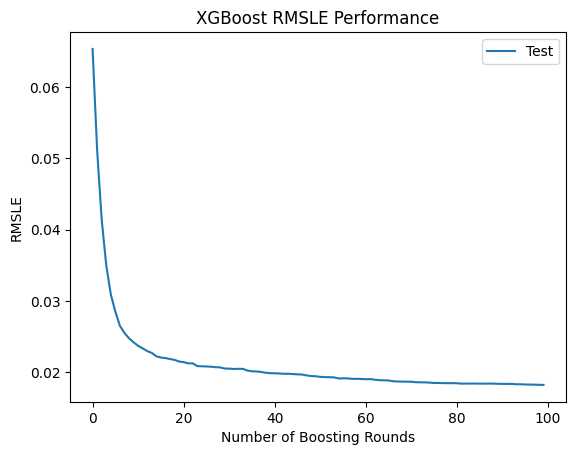

Final RMSLE on test set: 0.0182
r2 score: 0.9481657048331298
MAPE score: 0.009872499727022088
RMSE_score: 0.14878082579594706
Inverse Log of RMSLE:160.41862750629005


In [199]:

# Train a machine learning model
xgb = xgboost.XGBRegressor(n_estimators=100, eval_metric='rmsle', early_stopping_rounds=10, enable_categorical=True, verbosity=2)
# xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Retrieve the RMSLE values from the training process
results = xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# Plot the RMSLE values
plt.figure()
plt.plot(x_axis, results['validation_0']['rmsle'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSLE')
plt.title('XGBoost RMSLE Performance')
plt.show()

# Make predictions and evaluate the final RMSLE on the test set
y_pred = xgb.predict(X_test)
final_rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_test))))
print(f"Final RMSLE on test set: {final_rmsle:.4f}")
print(f"r2 score: {r2_score(y_pred, y_test)}")
print(f"MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}")
print(f"RMSE_score: {root_mean_squared_error(y_pred, y_test)}")
print(f"Inverse Log of RMSLE:{np.expm1(root_mean_squared_error(y_pred, y_test))*1000}")

Looking at the values above, specialreduction can be ignored as there are no non-zero values.

specialrehabilitation can be ignored as it appears infrequently and contributes little to overall settlement amount (max value £21).

SpecialMedication can be ignored as it appears infrequently and contributes little to overall settlement amount (max value £30).

accidentdate and Claim date are not relevant to the claim outcome

Columns with a high maximum value but low mean are candidates for grouping and further analysis is required.

specialadditionalinjury, specialfixes, specialhealthexpenses and specialloanervehicle could all be relevant groups, as they have low frequency but can be high value.

generaluplift - there are a small number of high values in this column

specialtripcosts and specialjourneyexpenses may be important - need to perform further analysis


Recommend investigating the relationship and correlations between the different types of columns (eg. can medical / trip+journey expenses be grouped)


## Histogram Visualisation

In [ ]:
# display histogram of numerical columns plotting only non-zero values against the settlement column
for column in ml_dataset.select_dtypes(include='Int64'):
    sns.histplot(ml_dataset[ml_dataset[column] != 0][column])
    plt.title(column)
    plt.show()

## Visualise correlations

In [ ]:
def check_correlation(df, target_col, feature_col):
    temp_df = df[[target_col, feature_col]]

    correlation = temp_df[target_col].corr(df[feature_col])
    # if correlation > 0.3 or correlation < -0.3:
    if -0.3 < correlation > 0.3:
        print(f'Correlation between {target_col} and {feature_col}: {correlation}')
    elif -0.95 < correlation > 0.95:
        print(f'Redundant Correlation between {target_col} and {feature_col}: {correlation}')
    else:
        # print(f'Correlation between {target_col} and {feature_col} not statistically significant: {correlation}')
        pass
        

In [ ]:
ml_dataset.head()

,settlementvalue,injuryprognosis,injurydescription,dominantinjury,whiplash,minorpsychologicalinjury,exceptionalcircumstances,generalfixed,generaluplift,generalrest,...,vehicletype,weatherconditions,vehicleage,driverage,numberofpassengers,policereportfiled,witnesspresent,gender,accidentdate,claimdate
0,520,5,Whiplash and minor bruises.,Arms,1,1,0,520,0,0,...,Motorcycle,Rainy,13,33,2,1,1,Male,2023-11-10 11:22,2024-06-11 11:22
1,870,2,Minor cuts and scrapes.,Multiple,1,1,0,260,0,520,...,Motorcycle,Snowy,4,45,2,1,1,Female,2023-06-25 00:55,2024-01-09 00:55
2,2140,7,Whiplash and minor bruises.,Legs,1,0,0,840,0,1400,...,Motorcycle,Sunny,9,45,2,1,0,Female,2020-02-23 17:43,2020-03-01 17:43
3,520,4,Minor cuts and scrapes.,Arms,1,1,0,520,0,0,...,Truck,Rainy,5,62,1,1,1,Female,2021-10-02 04:36,2021-10-13 04:36
4,260,3,Concussion and bruised ribs.,Arms,0,1,0,260,0,0,...,Motorcycle,Rainy,9,78,1,1,1,Other,2023-04-02 05:13,2023-04-14 05:13


In [37]:
import warnings

# suppress warnings for divide by zero errors
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for column in ml_dataset:
        if column != 'settlementvalue' and ml_dataset[column].dtype != 'object':
                for column2 in ml_dataset:
                    if column2 != (column or 'settlementvalue') and ml_dataset[column2].dtype != 'object':
                        check_correlation(ml_dataset, column, column2)

Correlation between injuryprognosis and settlementvalue: 0.5297105225481735
Correlation between injuryprognosis and generalfixed: 0.9494536896864154
Correlation between exceptionalcircumstances and generaluplift: 0.7911320833210876
Correlation between generalfixed and settlementvalue: 0.5363030401089954
Correlation between generalfixed and injuryprognosis: 0.9494536896864155
Correlation between generaluplift and exceptionalcircumstances: 0.7911320833210876
Correlation between generalrest and settlementvalue: 0.5582286322082783
Correlation between specialtherapy and settlementvalue: 0.31626202114903473
Correlation between specialearningsloss and settlementvalue: 0.3346780768964445


In [161]:
KEEP_COLS=['settlementvalue','injuryprognosis','generalfixed','exceptionalcircumstances','generaluplift',
'generalrest','specialtherapy','specialearningsloss','whiplash','exceptionalcircumstances','minorpsychologicalinjury',]

# KEEP_COLS=['settlementvalue','injuryprognosis','generaluplift','generalrest','specialtherapy','specialearningsloss']
small_feature_df = reduced_df.copy()
small_feature_df = small_feature_df[KEEP_COLS]
small_feature_df['settlementvalue'] = np.log1p(small_feature_df['settlementvalue'])
small_feature_df.head() 

,settlementvalue,injuryprognosis,generalfixed,exceptionalcircumstances,generaluplift,generalrest,specialtherapy,specialearningsloss,whiplash,exceptionalcircumstances,minorpsychologicalinjury
0,6.255750,1,520,0,0,0,0,0,1,0,1
1,6.769642,0,260,0,0,520,0,0,1,0,1
2,7.669028,2,840,0,0,1400,0,0,1,0,0
3,6.255750,1,520,0,0,0,0,0,1,0,1
4,5.564520,0,260,0,0,0,0,0,0,0,1


C:\Users\BB\AppData\Local\Temp\ipykernel_14028\1708567320.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  records = df.to_dict(orient='records')


[03:45:44] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (3385, 9, 14211).
r2 score: 0.8835182796492684
MAPE score: 0.015353866037990086
RMSE_score: 0.21274611094698212


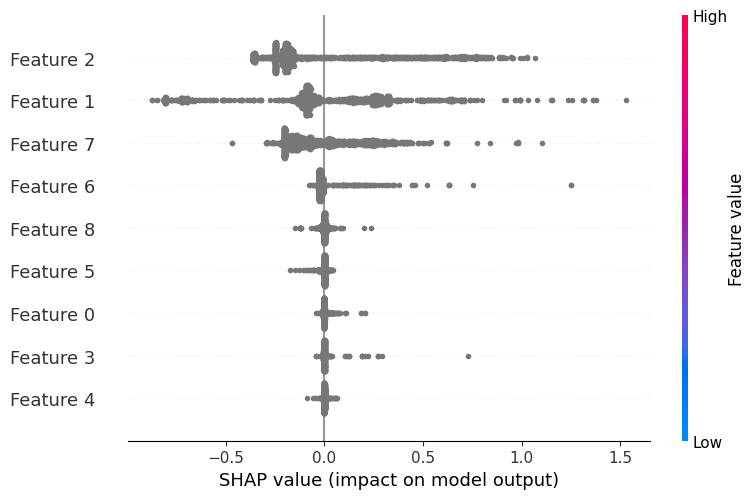

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [162]:
calc_shap(small_feature_df.copy(), 'XGBoost')                                                     

In [163]:
print(np.expm1(0.21274611094698212)*1000)

237.07053270359427


In [118]:
# create bins for injury prognosis based on the whiplash tariff scale
# Fill missing injuryprognosis with midpoint of prognosisgroup range

# reduced_df.head()

split_by_prognosis = reduced_df.copy()
# split_by_prognosis = split_by_prognosis.drop(columns=['accidenttype'])

# KEEP_COLS=['settlementvalue','injuryprognosis','whiplash','exceptionalcircumstances',
#            'minorpsychologicalinjury','generalfixed','generaluplift','generalrest',
#            'specialtherapy','specialearningsloss','accidenttype']
# split_by_prognosis = split_by_prognosis[KEEP_COLS]

split0_df = split_by_prognosis[split_by_prognosis['injuryprognosis'] == 0]
split1_df = split_by_prognosis[split_by_prognosis['injuryprognosis'] == 1]
split2_df = split_by_prognosis[split_by_prognosis['injuryprognosis'] == 2]
split3_df = split_by_prognosis[split_by_prognosis['injuryprognosis'] >= 3]

print(f"Number of records in split0_df: {len(split0_df.index)}")
print(f"Number of records in split1_df: {len(split1_df.index)}")
print(f"Number of records in split2_df: {len(split2_df.index)}")
print(f"Number of records in split3_df: {len(split3_df.index)}")

# split_by_prognosis['injuryprognosis'] = imputed_prognosis['injuryprognosis'].astype(int)
# ml_dataset = imputed_prognosis.copy()
# ml_dataset['injuryprognosis'].unique()

Number of records in split0_df: 669
Number of records in split1_df: 2238
Number of records in split2_df: 1532
Number of records in split3_df: 398


In [113]:
# split_by_prognosis = reduced_df.copy()
# split_by_prognosis = split_by_prognosis.drop(columns=['accidenttype'])

# KEEP_COLS=['settlementvalue','injuryprognosis','whiplash','exceptionalcircumstances',
#            'minorpsychologicalinjury','generalfixed','generaluplift','generalrest',
#            'specialtherapy','specialearningsloss','accidenttype']
# split_by_prognosis = split_by_prognosis[KEEP_COLS]

whip_split0_df = split1_df[split1_df['whiplash'] == 0]
whip_split1_df = split1_df[split1_df['whiplash'] == 1]

[02:41:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (468, 37, 1917).
r2 score: 0.9053515195846558
MAPE score: 0.11466345191001892
RMSE_score: 164.8460693359375


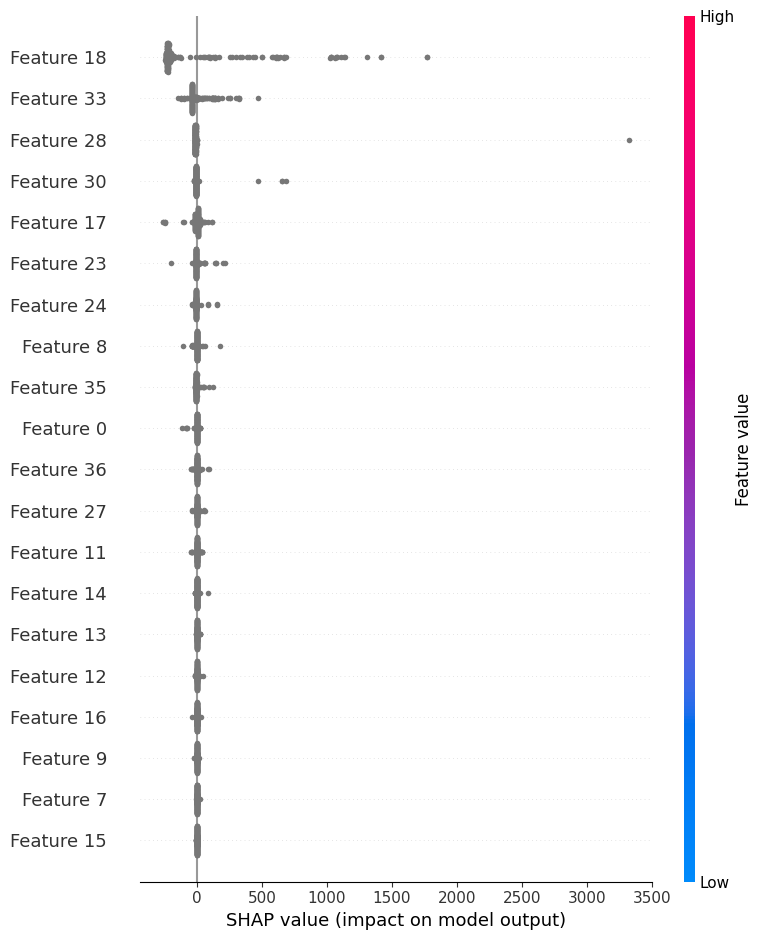

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [119]:
calc_shap(split0_df.copy(), 'XGBoost')

[02:41:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1566, 39, 8986).
r2 score: 0.946743369102478
MAPE score: 0.06407073140144348
RMSE_score: 156.35540771484375


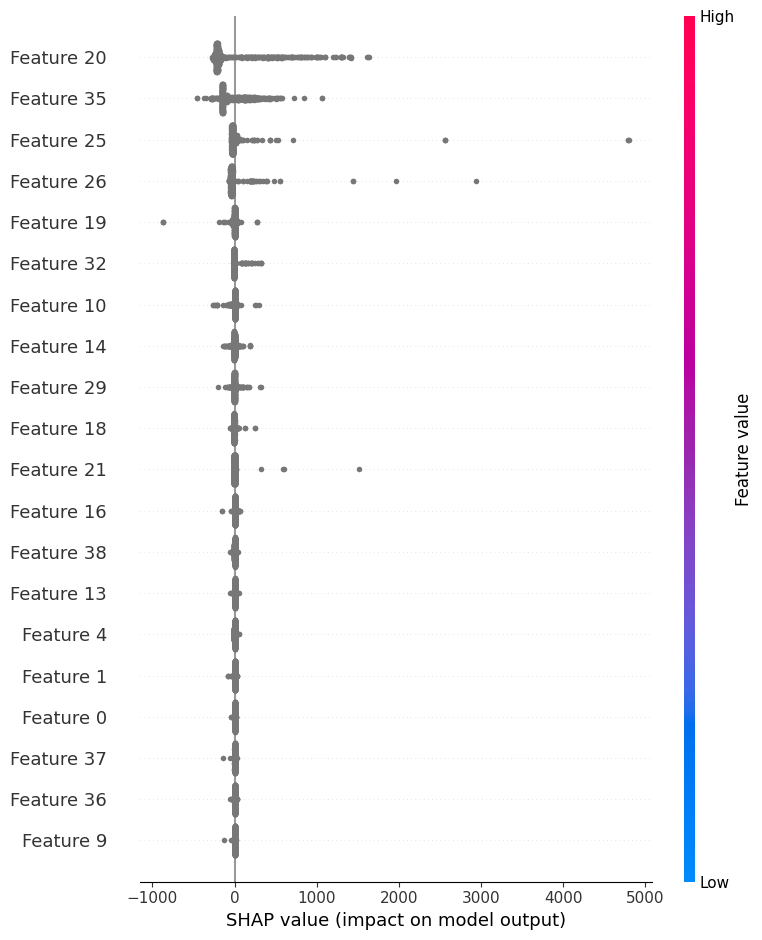

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [120]:
calc_shap(split1_df.copy(), 'XGBoost')

[02:41:39] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1072, 38, 6434).
r2 score: 0.7438352108001709
MAPE score: 0.06236044690012932
RMSE_score: 354.5101623535156


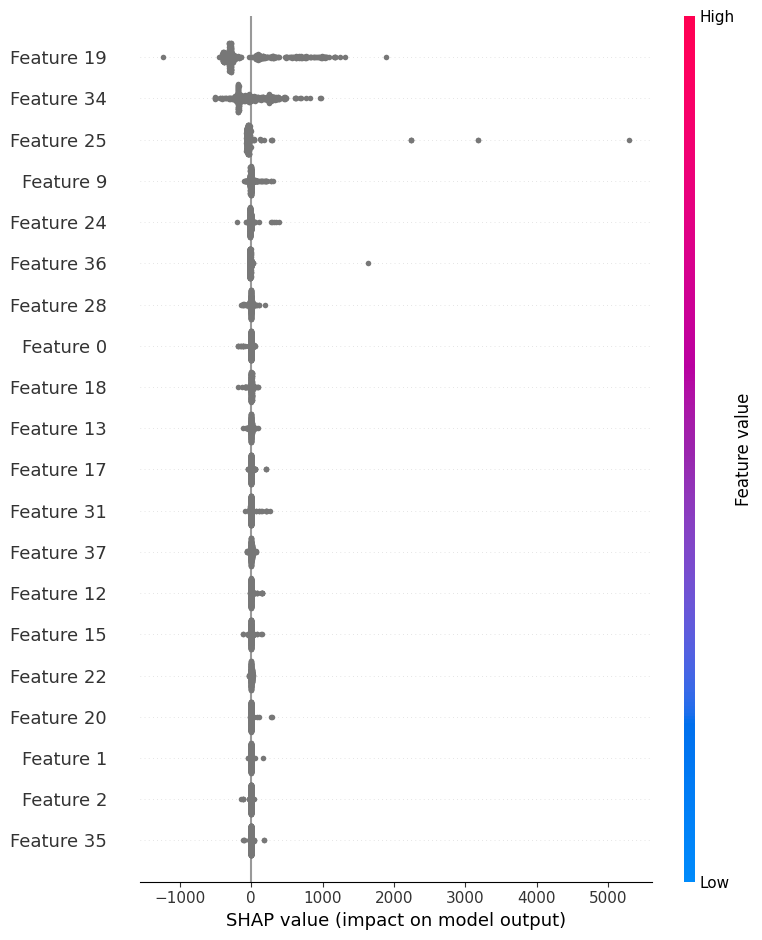

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [121]:
calc_shap(split2_df.copy(), 'XGBoost')

[02:41:43] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (278, 35, 1667).
r2 score: 0.9304200410842896
MAPE score: 0.039398692548274994
RMSE_score: 222.12391662597656


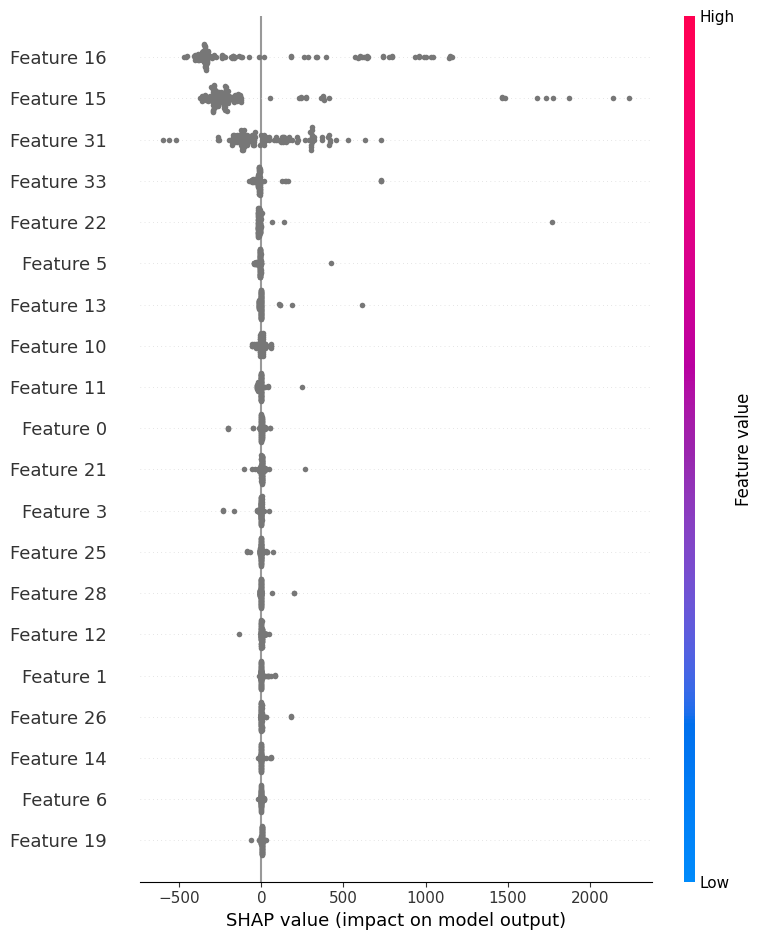

AttributeError: 'csr_matrix' object has no attribute 'columns'

In [122]:
calc_shap(split3_df.copy(), 'XGBoost')